In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox
import config
import random
from dgl import DGLGraph


Using backend: pytorch


TypeError: write_graphml_lxml() got an unexpected keyword argument 'filepath'

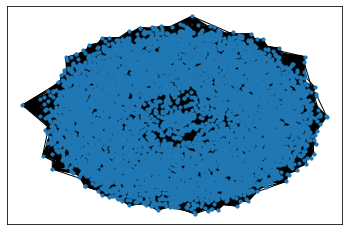

In [2]:
#g1 = nx.relaxed_caveman_graph(15, 50, 0.2)
#len(g)
partition_sizes = [random.randint(30, 60) for i in range(200)]
g = nx.random_partition_graph(partition_sizes,
                              p_in=.1,
                              p_out=.01,
                              seed=10)
nx.draw_networkx(g, with_labels=False, node_size=10)
#plt.draw()



In [6]:
nx.write_gpickle(g, f"{config.gnn_path}/pickle/training_graph.gpickle")

In [2]:
g = nx.read_gpickle(f"{config.gnn_path}/pickle/training_graph.gpickle")

In [3]:
g.size(weight="weight")

423971.0

In [4]:
# assign weight to all edges
nx.set_edge_attributes(g, 1, "weight")

# spread 10000 weight among edges in each partition
partitions = g.graph["partition"]
i = 1
for p in partitions:
    print(f"Labeling nodes in partition {i}")
    for node in tuple(p):
        attrs = {node: {"community": i}}
        nx.set_node_attributes(g, attrs)
    print(f"Partition {i} nodes are labelled")
    print(f"Adding weights to partition {i}")
    spread = 10000
    while spread > 0:
        n = random.randint(15, 200)
        u = random.choice(tuple(p))
        v = random.choice(tuple(p))
        if g.has_edge(u, v) and (spread - n > 0):
            weight_before = g[u][v]["weight"]
            g[u][v]["weight"] = weight_before + n
            spread = spread - n
        elif spread - n < 0:
            break
    print(f"Partition {i} weights assigned"
          f"\n===========================")
    i += 1

Labeling nodes in partition 1
Partition 1 nodes are labelled
Adding weights to partition 1
Partition 1 weights assigned
Labeling nodes in partition 2
Partition 2 nodes are labelled
Adding weights to partition 2
Partition 2 weights assigned
Labeling nodes in partition 3
Partition 3 nodes are labelled
Adding weights to partition 3
Partition 3 weights assigned
Labeling nodes in partition 4
Partition 4 nodes are labelled
Adding weights to partition 4
Partition 4 weights assigned
Labeling nodes in partition 5
Partition 5 nodes are labelled
Adding weights to partition 5
Partition 5 weights assigned
Labeling nodes in partition 6
Partition 6 nodes are labelled
Adding weights to partition 6
Partition 6 weights assigned
Labeling nodes in partition 7
Partition 7 nodes are labelled
Adding weights to partition 7
Partition 7 weights assigned
Labeling nodes in partition 8
Partition 8 nodes are labelled
Adding weights to partition 8
Partition 8 weights assigned
Labeling nodes in partition 9
Partition 

In [5]:
g.size(weight="weight")

2402334.0

In [10]:
nx.write_gpickle(g, f"{config.gnn_path}/pickle/training_graph_weighted.gpickle")


In [6]:
g = nx.read_gpickle(f"{config.gnn_path}/pickle/training_graph_weighted.gpickle")


In [7]:
# convert networkx graph to dgl graph, extract node and edge features
dgl_g = DGLGraph()
dgl_g.from_networkx(g, edge_attrs=["weight"], node_attrs=["block"])
